# 09.03 Model Persistence

It takes a moment to train a model,
moreover since that normally mean training several models and preforming model selection.
The reason to train a model is for it to be useful against real problems,
often we want to use the model against data that we do not have whilst we are training it.
Therefore we want to save the trained model for later reuse.

![Bow Tie](sl-bow-tie.svg)

<div style="text-align:right;"><sup>sl-bow-tie.svg</sup></div>

In Python we can simply use `pickle` to dump a model to a file.
Yet, `pickle` is particularly ineffective and slow at serializing `NumPy` arrays.
A better option is `joblib` which uses `NumPy`'s internal memory mappings
(memory mapped files on systems that support it) or stream compression
to reduce the size of the file,
the time to load it from disk and even the size of the model in memory.
`joblib` has a `pickle` interface and we can use the below to deal with
systems that may or may not have `joblib` installed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-talk')
try:
    from joblib import dump, load
except ImportError:
    from pickle import dump, load

Let's create some regression data and build a `RandomForestRegressor` from it.

In [2]:
n_points = 512
X = np.sort(200 * np.random.rand(n_points, 2) - 100, axis=0)
y = np.array(np.pi*X[:, 0] * np.sin(X[:, 1])) + 0.5 - np.random.rand(n_points)
X.shape, y.shape

((512, 2), (512,))

The random forest has a hyperparameter that we will tune using a grid search,
the number of trees used for the regression.
We will use cross validation to determine this hyperparameter,
therefore the grid search will see all the data in the cross validation.
This means that the final cross validation score may be overestimated.

Before performing the grid search and the cross validation we will split
the data into training and test sets.
Then we run cross validation on the training set only.

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
grid = GridSearchCV(RandomForestRegressor(),
                    {'n_estimators': [10, 20, 50, 100, 200]}, cv=5)
grid.fit(X_train, y_train)
grid.best_score_

0.7927991013819178

That's a reasonable score,
let's see how what hyperparameters we got.

In [4]:
grid.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

And let's see if we are not overestimating the generalization of this model.
We can do this since we did keep a test set on the side until now.

In [5]:
model = grid.best_estimator_
model.score(X_test, y_test)

0.837744378265593

The real generalization estimate is somewhere in between,
closer to the lowest value.
Let's have a quick visual look as well, since this model does not have too many dimensions.

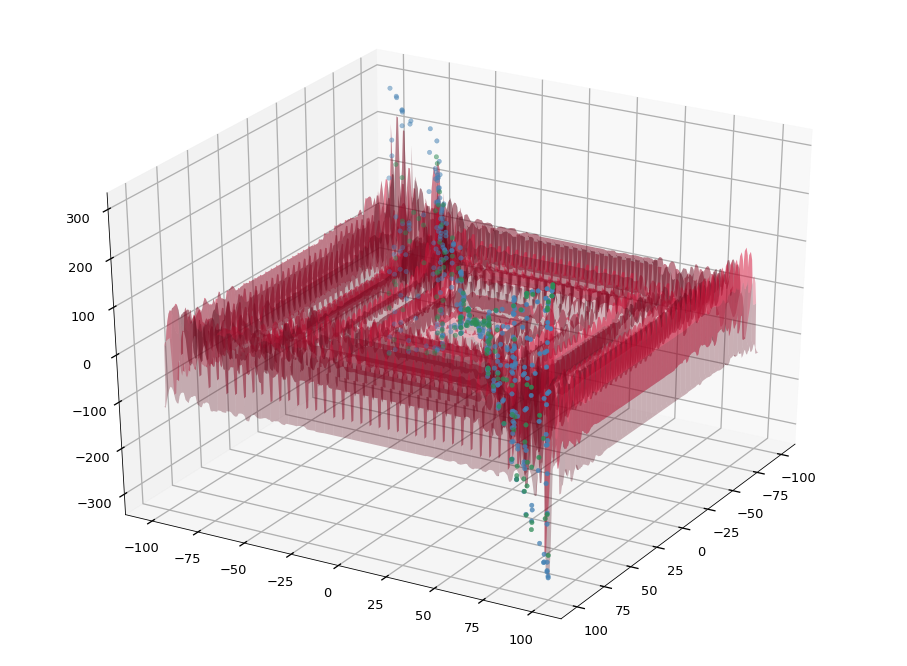

In [6]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:, 0], X_train[:, 1], y_train, color='steelblue')
ax.scatter(X_test[:, 0], X_test[:, 1], y_test, color='seagreen')
n_points = 256
pred_pi = np.linspace(-100, 100, n_points)
pred_sin = np.linspace(-100, 100, n_points)
gpi, gsin = np.meshgrid(pred_pi, pred_sin)
X_pred = np.c_[gpi.ravel(), gsin.ravel()]
y_pred = model.predict(X_pred)
ax.plot_surface(gpi, gsin, y_pred.reshape(n_points, n_points), alpha=0.3, color='crimson')
ax.view_init(elev=30., azim=30)

The features were taken from the same array and are dependent on each other:
when one feature increases the other increases too.
This is because we sorted the values.
As an exercise you can go back to the generation of the data an remove `np.sort`,
the graph will look very differently but also the model will score much worse.

Yet, let's say that this model is good for our purposes because we know,
or assume, that the features are really dependent on each other.
And, since we are confident about this model, we should save it.

In [7]:
with open('rfr.pickle', 'wb') as f:
    dump(model, f)

This just created a file called `rcf.pickle` in the current directory.
The file is a binary (pickled) representation of the model (object) we juts used.
We can read it back now into a different variable.

In [8]:
with open('rfr.pickle', 'rb') as f:
    rfc = load(f)

And we can check if the model loaded back from this file is the same one.

In [9]:
rfc.score(X_test, y_test)

0.837744378265593

This is exactly the same test score ($R2$) as before,
we can be quite confident that we got the same model back.

## Caveats

The interoperability between different versions of Python's `pickle` module is poor.
In other words, exchanging models between Python 2 and Python 3 projects
through `pickle` is a very bad idea.
That said, Python 2 is reaching EOL in 2020, where this concern should end.

More advanced uses of `joblib`, e.g. gzipped files, do not keep full compatibility to `pickle`.
It isn't anything that cannot be worked around by uncompressing a file before unpickling
but one needs to be consistent on how to treat persisted models,
the files contain very little metadata on how to load them back.

## `joblib`

Is much more extensive than just persisting models.
The main aim of the library is to automate several processes in a machine learning
pipeline by memoizing intermediate results to disk, as extended pickle.
Two things that the library specializes are:

- Memoize results of huge computations on disk,
  so one does not necessarily need to re-run the entire processing if something goes wrong.

- Memory map `NumPy` arrays during parallel processing,
  allowing separate processes to share memory and preventing copying huge arrays between processes.

For training big models on a single machine, `joblib` helps a good deal.

## Should I always persist my model?

Not necessarily.
An ML model will wander off course over time,
i.e. the real world will change in a way that the model do not reflect it anymore.
Often one needs to retrain a model periodically for it to be useful.
One would collect the data that is thrown at the model and construct a new training
set by mixing the new data with the old training set.

A case where retraining a model makes sense are web services.
A web service will run several models of the same kind, and will predict values for user requests.
The service runs several models for load balancing,
i.e. even when one of the machines goes down the service can still respond to users.
These machines run non-stop but sometimes need to be taken down for maintenance:
a machine is taken down, updated, restarted, tested and only then placed back into the load balancing.
Since the machine restart may take a while,
re-training the model that is part of the service during this restart is a good idea.
The re-trained model knows about new training data and will be (hopefully) better.